In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:

class Points:
    def __init__(self, coordinates, label=None):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.label = label
    
    def __lt__(self, other):
        """Define la relación de orden entre dos puntos."""
        return (self.y > other.y) or (self.y == other.y and self.x < other.x)

    def __str__(self):
        return f"{self.label} ({self.x}, {self.y})"
    def __repr__(self):
        return self.__str__()
    
def generate_random_points(N, low_value, high_value, integer=True): 
    """Genera N puntos aleatorios en un rango especificado."""
    coordinates = []
    for i in range(N):
        x = int(np.random.uniform(low_value, high_value)) if integer else np.random.uniform(low_value, high_value)
        y = int(np.random.uniform(low_value, high_value)) if integer else np.random.uniform(low_value, high_value)
        label = f"P{i+1}"
        p = Points((x, y), label)
        coordinates.append(p)
    return coordinates


In [16]:
class Segment:
    segment_count = 0 
    def __init__(self, upper, lower):
        """ Crea un segmento ordenando los puntos según la relación de orden. """
        if upper < lower:  # Usamos la relación de orden en Points
            self.upper = upper  # Extremo superior
            self.lower = lower  # Extremo inferior
        else:
            self.upper = lower
            self.lower = upper

        Segment.segment_count += 1
        self.label = f"S{Segment.segment_count}"  # Nombre único del segmento


    def __str__(self):
        """ Representación legible del segmento. """
        return f"{self.label} (Upper: {self.upper.label}, Lower: {self.lower.label})"

    def __lt__(self, other):
        """ Compara segmentos en la línea de barrido. """
        return self.upper < other.upper  # Se usa la relación de orden entre puntos
    
    def __repr__(self):
        return self.__str__()

    def intersecta_con(self, other):
        """ Determina si dos segmentos se cruzan. """
        def ccw(A, B, C):
            """ Función auxiliar para determinar si tres puntos están en orden antihorario. """
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)

        # Se determina si los segmentos se cruzan verificando la orientación de los puntos
        return (ccw(self.upper, other.upper, other.lower) != ccw(self.lower, other.upper, other.lower) and
                ccw(self.upper, self.lower, other.upper) != ccw(self.upper, self.lower, other.lower))
    
    def reset_count(self):
        Segment.segment_count = 0

def generate_random_segments(N, low_value, high_value):
    """Genera N segmentos aleatorios."""
    points = generate_random_points(N * 2, low_value, high_value)  # Generamos 2N puntos
    segments = [Segment(points[i], points[i + 1]) for i in range(0, len(points), 2)]
    return segments

def plot_segments(segments):
    """Visualiza los segmentos en un gráfico."""
    plt.figure(figsize=(6, 6))
    for seg in segments:
        # Cambiamos la etiqueta para mostrar el nombre del segmento
        plt.plot([seg.upper.x, seg.lower.x], [seg.upper.y, seg.lower.y], 
                 marker='o', 
                 label=seg.label)  # Usamos seg.label en lugar de f"{seg.upper.label}-{seg.lower.label}"
        
        # Mantenemos las etiquetas de los puntos
        plt.text(seg.upper.x, seg.upper.y, seg.upper.label, 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right')
        plt.text(seg.lower.x, seg.lower.y, seg.lower.label, 
                fontsize=12, verticalalignment='top', horizontalalignment='right')
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Visualización de Segmentos")
    plt.legend(loc='upper right')  # Descomentamos plt.legend() y especificamos la ubicación
    plt.grid()
    plt.show()

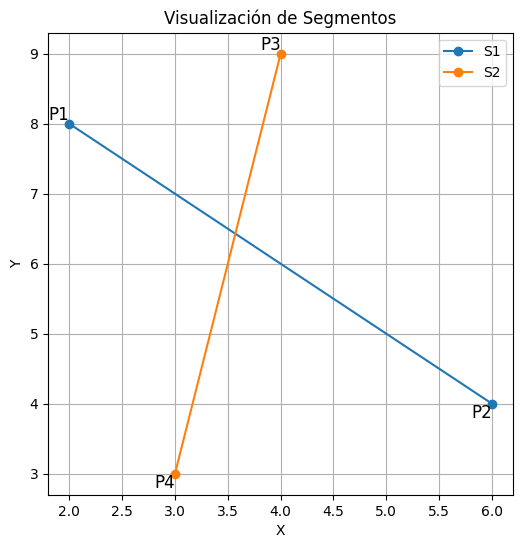

In [10]:
p1 = Points((2, 8), "P1")
p2 = Points((6, 4), "P2")
p3 = Points((4, 9), "P3")
p4 = Points((3, 3), "P4")

s1 = Segment(p1, p2)
s2 = Segment(p3, p4)

segments = [s1,s2]

plot_segments(segments)

In [11]:
class Evento:
    INICIO = "INICIO"
    FIN = "FIN"
    INTERSECCIÓN = "INTERSECCIÓN"

    def __init__(self, punto, tipo, segmentos=None):
        """
        Un evento en la línea de barrido.
        :param punto: Punto donde ocurre el evento.
        :param tipo: Tipo de evento (INICIO, FIN, INTERSECCIÓN).
        :param segmentos: Segmentos involucrados en el evento (lista).
        """
        self.punto = punto
        self.tipo = tipo
        self.segmentos = segmentos if segmentos else []

    def __lt__(self, other):
        """ Ordena los eventos en la lista de eventos. """
        if self.punto.y != other.punto.y:
            return self.punto.y > other.punto.y  # Primero el de mayor Y (barrido descendente)
        return self.punto.x < other.punto.x  # Si Y es igual, menor X primero

    def __str__(self):
        """ Representación legible del evento. """
        segmentos_str = ", ".join([s.label for s in self.segmentos])
        return f"Evento({self.tipo}, Punto={self.punto.label}, Segmentos=[{segmentos_str}])"

def insertar_evento(eventos, nuevo_evento):
    """
    Inserta un evento en la lista ordenada de eventos.
    """
    index = 0
    while index < len(eventos) and eventos[index] < nuevo_evento:
        index += 1
    eventos.insert(index, nuevo_evento)

def generar_eventos(segments):
    """
    Genera la lista de eventos a partir de una lista de segmentos.
    Retorna una lista ordenada de eventos.
    """
    eventos = []
    for seg in segments:
        insertar_evento(eventos, Evento(seg.upper, Evento.INICIO, [seg]))  # Evento de inicio
        insertar_evento(eventos, Evento(seg.lower, Evento.FIN, [seg]))  # Evento de fin
    return eventos


In [74]:
class NodoELB:
    def __init__(self, segmento):
        self.segmento = segmento
        self.left = None
        self.right = None

class ELB:
    def __init__(self):
        self.raiz = None
        self.y_actual = None

    def insert(self, entrada):
        """
        Inserta un evento o segmento en el árbol.
        :param entrada: Puede ser un Evento o un Segmento
        """
        self.y_actual = entrada.punto.y if isinstance(entrada, Evento) else self.y_actual
        
        if isinstance(entrada, Evento):
            for segmento in entrada.segmentos:
                self.raiz = self._insert(self.raiz, segmento)
        elif isinstance(entrada, Segment):
            self.raiz = self._insert(self.raiz, entrada)
        

    def _insert(self, nodo, segmento):
        """Inserta un segmento en el árbol basándose en la intersección con la línea de barrido."""
        if nodo is None:
            return NodoELB(segmento)
        
        # Si encontramos el mismo segmento, no lo insertamos
        if nodo.segmento == segmento:
            print(f"  Segmento {segmento} ya existe en el nodo actual")
            return nodo
        
        x_seg = self.interseccion_segmento_y(segmento, self.y_actual)
        x_nodo = self.interseccion_segmento_y(nodo.segmento, self.y_actual)
        
        if x_seg < x_nodo:
            nodo.left = self._insert(nodo.left, segmento)
        else:
            nodo.right = self._insert(nodo.right, segmento)
        
        return nodo
    
    
    def interseccion_segmento_y(self, segmento, y_actual):
        """ Calcula la coordenada X donde el segmento intersecta la línea de barrido en y_actual. """
        x1, y1 = segmento.upper.x, segmento.upper.y
        x2, y2 = segmento.lower.x, segmento.lower.y
        
        if y1 == y2:
            return x1  # Segmento horizontal, tomamos x de cualquier extremo
        
        pendiente = (x2 - x1) / (y2 - y1)
        x_interseccion = x1 + pendiente * (y_actual - y1)
        
        return x_interseccion
    
    def inorder(self):
        """ Retorna una lista de segmentos ordenados en el árbol. """
        return self._inorder(self.raiz, [])
    
    def _inorder(self, nodo, lista):
        if nodo is not None:
            self._inorder(nodo.left, lista)
            lista.append(nodo.segmento)
            self._inorder(nodo.right, lista)
        return lista
    
    def _balancear(self, segmentos):
        """ Crea un árbol balanceado a partir de una lista ordenada de segmentos. """
        if not segmentos:
            return None
        mid = len(segmentos) // 2
        nodo = NodoELB(segmentos[mid])
        nodo.left = self._balancear(segmentos[:mid])
        nodo.right = self._balancear(segmentos[mid + 1:])
        return nodo
    

    def eliminar_segmento(self, segmento):
        """ Elimina un nodo que contiene un segmento específico en el árbol. """
        self.raiz = self._eliminar_segmento(self.raiz, segmento)
    
    def _eliminar_segmento(self, nodo, segmento):
        """ Busca y elimina el nodo que contiene el segmento en el árbol. """
        if nodo is None:
            return None

        x_seg = self.interseccion_segmento_y(segmento, self.y_actual)
        x_nodo = self.interseccion_segmento_y(nodo.segmento, self.y_actual)

        if segmento == nodo.segmento:
            # Caso 1: Nodo sin hijos
            if nodo.left is None and nodo.right is None:
                return None
            # Caso 2: Nodo con un solo hijo
            if nodo.left is None:
                return nodo.right
            if nodo.right is None:
                return nodo.left
            # Caso 3: Nodo con dos hijos
            sucesor = self._encontrar_min(nodo.right)
            nodo.segmento = sucesor.segmento
            nodo.right = self._eliminar_segmento(nodo.right, sucesor.segmento)
            return nodo

        if x_seg < x_nodo:
            nodo.left = self._eliminar_segmento(nodo.left, segmento)
        else:
            nodo.right = self._eliminar_segmento(nodo.right, segmento)

        return nodo

    def _encontrar_min(self, nodo):
        """ Encuentra el nodo con el valor mínimo en el subárbol derecho. """
        while nodo.left is not None:
            nodo = nodo.left
        return nodo
   
    def ordenar_justo_debajo(self, p, epsilon=1e-5):
        """
        Reorganiza los segmentos en TAO según su intersección con la línea de barrido justo debajo de p.
        :param p: El punto de referencia.
        :param epsilon: Pequeño valor para ajustar la línea de barrido.
        """
        segmentos_antes = self.inorder()
        self.y_actual = p.y - epsilon
        
        # Ordenar segmentos basados en su intersección con la nueva línea de barrido
        segmentos_ordenados = sorted(segmentos_antes, 
                                    key=lambda s: self.interseccion_segmento_y(s, self.y_actual))
        
        # Solo reconstruir el árbol si hubo cambios en el orden
        if segmentos_ordenados != segmentos_antes:
            self.raiz = self._balancear(segmentos_ordenados)
        
    def encontrar_vecinos(self, p):
        """
        Encuentra los segmentos inmediatamente a la izquierda (Sl) y a la derecha (Sr) de p en TAO.
        :param p: Objeto de tipo Points (punto actual de la línea de barrido).
        :return: (Sl, Sr) → Segmentos vecinos izquierdo y derecho.
        """
        segmentos = self.inorder()  # Obtener segmentos en orden de intersección con la línea de barrido
        Sl, Sr = None, None

        for segmento in segmentos:
            x_interseccion = self.interseccion_segmento_y(segmento, p.y)

            if x_interseccion < p.x:
                Sl = segmento  # Último segmento que queda a la izquierda
            elif x_interseccion > p.x and Sr is None:
                Sr = segmento  # Primer segmento que queda a la derecha
                break  # No necesitamos seguir buscando

        return Sl, Sr

    def encontrar_segmentos_izquierda(self, p, conjunto_cp_up):
        """
        Encuentra S' (el segmento más a la izquierda en C(p) U U(p)) dentro de TAO.
        Encuentra Sl (el segmento inmediatamente a la izquierda de p en TAO).
        
        :param p: Punto de referencia en la línea de barrido.
        :param conjunto_cp_up: Conjunto (C(p) ∪ U(p)) de segmentos activos en p.
        :return: (S', Sl) → Segmento más a la izquierda en C(p) ∪ U(p) y segmento inmediatamente a la izquierda de p.
        """
        segmentos = self.inorder()  # Obtener segmentos en orden
        S_prima, Sl = None, None

        # Buscar S' (segmento más a la izquierda en C(p) ∪ U(p))
        min_x = float('inf')
        for segmento in conjunto_cp_up:
            x_interseccion = self.interseccion_segmento_y(segmento, p.y)
            if x_interseccion < min_x:
                min_x = x_interseccion
                S_prima = segmento

        # Buscar Sl (segmento inmediatamente a la izquierda de p)
        for segmento in segmentos:
            x_interseccion = self.interseccion_segmento_y(segmento, p.y)
            if x_interseccion < p.x:
                Sl = segmento  # Último segmento antes de p
            else:
                break  # No necesitamos seguir buscando

        return S_prima, Sl

    def encontrar_segmentos_derecha(self, p, conjunto_cp_up):
            """
            Encuentra S'' (el segmento más a la derecha en C(p) U U(p)) dentro de TAO.
            Encuentra Sr (el segmento inmediatamente a la derecha de p en TAO).
            
            :param p: Punto de referencia en la línea de barrido.
            :param conjunto_cp_up: Conjunto (C(p) ∪ U(p)) de segmentos activos en p.
            :return: (S'', Sr) → Segmento más a la derecha en C(p) ∪ U(p) y segmento inmediatamente a la derecha de p.
            """
            segmentos = self.inorder()  # Obtener segmentos en orden
            S_doble_prima, Sr = None, None

            # Buscar S'' (segmento más a la derecha en C(p) ∪ U(p))
            max_x = float('-inf')
            for segmento in conjunto_cp_up:
                x_interseccion = self.interseccion_segmento_y(segmento, p.y)
                if x_interseccion > max_x:
                    max_x = x_interseccion
                    S_doble_prima = segmento

            # Buscar Sr (segmento inmediatamente a la derecha de p)
            for segmento in segmentos:
                x_interseccion = self.interseccion_segmento_y(segmento, p.y)
                if x_interseccion > p.x:
                    Sr = segmento  # Primer segmento después de p
                    break  # No necesitamos seguir buscando

            return S_doble_prima, Sr




def manipular_punto_p(p, segmentos_activos, epsilon=1e-10):
    """
    Clasifica los segmentos relacionados con un punto p.
    
    :param p: Punto de referencia
    :param segmentos_activos: Segmentos actuales en la línea de barrido
    :param epsilon: Tolerancia para comparaciones numéricas
    :return: (upper_p, lower_p, contain_p)
    """
    upper_p = set()
    lower_p = set()
    contain_p = set()

    print(f"\nAnalizando punto {p}")
    print(f"Segmentos activos a analizar: {segmentos_activos}")

    for segmento in segmentos_activos:
        # Verificar si el punto es extremo superior
        if abs(p.x - segmento.upper.x) < epsilon and abs(p.y - segmento.upper.y) < epsilon:
            # print(f"  {segmento} tiene a {p} como punto superior")
            upper_p.add(segmento)
            continue
            
        # Verificar si el punto es extremo inferior
        if abs(p.x - segmento.lower.x) < epsilon and abs(p.y - segmento.lower.y) < epsilon:
            # print(f"  {segmento} tiene a {p} como punto inferior")
            lower_p.add(segmento)
            continue

        # Si no es extremo, verificar si está contenido en el segmento
        def punto_en_segmento(p, segmento):
            """
            Verifica si un punto está en un segmento usando distancias.
            """
            def distancia_punto_a_linea(p, a, b):
                num = abs((b.x - a.x) * (a.y - p.y) - (a.x - p.x) * (b.y - a.y))
                den = np.sqrt((b.x - a.x)**2 + (b.y - a.y)**2)
                return num/den if den != 0 else 0
            
            # Verificar si el punto está cerca de la línea
            if distancia_punto_a_linea(p, segmento.upper, segmento.lower) > epsilon:
                return False
                
            # Verificar si el punto está dentro del rango del segmento
            x_min, x_max = min(segmento.upper.x, segmento.lower.x), max(segmento.upper.x, segmento.lower.x)
            y_min, y_max = min(segmento.upper.y, segmento.lower.y), max(segmento.upper.y, segmento.lower.y)
            
            return (x_min - epsilon <= p.x <= x_max + epsilon and 
                    y_min - epsilon <= p.y <= y_max + epsilon)

        if punto_en_segmento(p, segmento):
            # print(f"  {segmento} contiene a {p} en su interior")
            contain_p.add(segmento)

    # print(f"\nResultados para punto {p}:")
    # print(f"  Upper_p: {upper_p}")
    # print(f"  Lower_p: {lower_p}")
    # print(f"  Contain_p: {contain_p}")
    
    return upper_p, lower_p, contain_p

def evaluar_interseccion(seg1, seg2):
    """
    Evalúa si dos segmentos se cruzan y, si lo hacen, crea un nuevo evento de intersección.
    :param seg1: Primer segmento
    :param seg2: Segundo segmento
    :return: Evento de intersección si se cruzan, None en caso contrario.
    """
    
    # Verificación de tipos
    if not isinstance(seg1, Segment) or not isinstance(seg2, Segment):
        print(f"Error: Los argumentos deben ser de tipo Segment")
        print(f"Tipo de seg1: {type(seg1)}")
        print(f"Tipo de seg2: {type(seg2)}")
        return None

    def ccw(A, B, C):
        """ 
        Determina si los puntos están en orden antihorario.
        Si el resultado es positivo → Antihorario
        Si es negativo → Horario
        Si es 0 → Son colineales
        """
        return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)

    # Verificar si los segmentos se cruzan usando el criterio de orientación
    # print(seg1,seg2)
    A, B = seg1.upper, seg1.lower
    C, D = seg2.upper, seg2.lower

    intersecan = (ccw(A, C, D) != ccw(B, C, D)) and (ccw(A, B, C) != ccw(A, B, D))

    if not intersecan:
        return None  # No hay intersección

    # Si se cruzan, calcular la intersección real
    def calcular_interseccion(A, B, C, D):
        """ Calcula el punto de intersección entre los segmentos AB y CD. """
        det = (A.x - B.x) * (C.y - D.y) - (A.y - B.y) * (C.x - D.x)

        if det == 0:
            return None  # Son colineales o paralelos

        x_inter = ((A.x * B.y - A.y * B.x) * (C.x - D.x) - (A.x - B.x) * (C.x * D.y - C.y * D.x)) / det
        y_inter = ((A.x * B.y - A.y * B.x) * (C.y - D.y) - (A.y - B.y) * (C.x * D.y - C.y * D.x)) / det

        return Points((x_inter, y_inter),label="Pi")

    punto_interseccion = calcular_interseccion(A, B, C, D)
    print(f"Objeto punto interseccion: {punto_interseccion}")

    if punto_interseccion is None:
        return None

    # Crear un nuevo evento de intersección
    nuevo_evento = Evento(punto_interseccion, Evento.INTERSECCIÓN, [seg1, seg2])
    
    return nuevo_evento

def validar_evento_interseccion(evento, y_actual, epsilon=1e-10):
    """
    Valida si un evento de intersección es válido (está por debajo de la línea de barrido actual)
    """
    if evento is None or evento.tipo != Evento.INTERSECCIÓN:
        return False
        
    return evento.punto.y < y_actual - epsilon




=== Creación de Segmentos ===
Creado S1 (Upper: P1, Lower: P2)
Creado S2 (Upper: P4, Lower: P3)
Creado S3 (Upper: P5, Lower: P6)


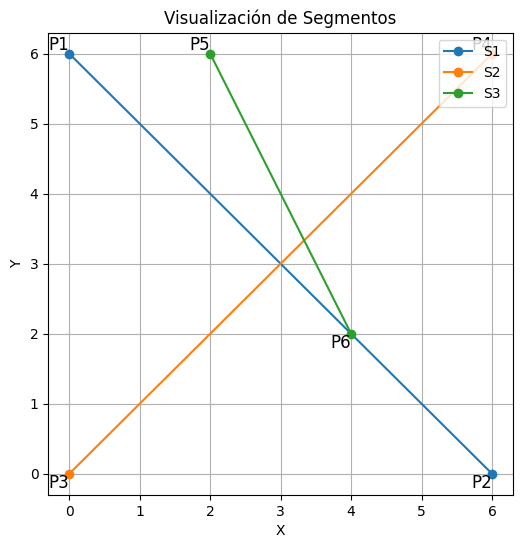


=== Generando eventos iniciales ===
Eventos iniciales generados: 6
  Evento(INICIO, Punto=P1, Segmentos=[S1])
  Evento(INICIO, Punto=P5, Segmentos=[S3])
  Evento(INICIO, Punto=P4, Segmentos=[S2])
  Evento(FIN, Punto=P6, Segmentos=[S3])
  Evento(FIN, Punto=P3, Segmentos=[S2])
  Evento(FIN, Punto=P2, Segmentos=[S1])

=== Iniciando procesamiento de eventos ===

--- Iteración 1 ---
Procesando evento: Evento(INICIO, Punto=P1, Segmentos=[S1])
Estado de la línea de barrido después de inserción:
Segmentos activos: [S1 (Upper: P1, Lower: P2)]

--- Iteración 2 ---
Procesando evento: Evento(INICIO, Punto=P5, Segmentos=[S3])
Estado de la línea de barrido después de inserción:
Segmentos activos: [S1 (Upper: P1, Lower: P2), S3 (Upper: P5, Lower: P6)]

Punto actual: P5 (2, 6)
Segmentos activos: [S1 (Upper: P1, Lower: P2), S3 (Upper: P5, Lower: P6)]

Analizando punto P5 (2, 6)
Segmentos activos a analizar: [S1 (Upper: P1, Lower: P2), S3 (Upper: P5, Lower: P6)]
Clasificación de segmentos:
  Upper_p: {

In [77]:
# Definimos los puntos y segmentos
p1 = Points((0, 6), "P1")
p2 = Points((6, 0), "P2")
p3 = Points((0, 0), "P3")
p4 = Points((6, 6), "P4")
p5 = Points((2, 6), "P5")
p6 = Points((4, 2), "P6")

s0 = Segment(p1, p2)
s0.reset_count()
print("\n=== Creación de Segmentos ===")
s1 = Segment(p1, p2)
print(f"Creado {s1}")
s2 = Segment(p3, p4)
print(f"Creado {s2}")
s3 = Segment(p5, p6)
print(f"Creado {s3}")

segments = [s1, s2, s3]
plot_segments(segments)
print("\n=== Generando eventos iniciales ===")
eventos_cola = generar_eventos(segments)
print(f"Eventos iniciales generados: {len(eventos_cola)}")
for e in eventos_cola:
    print(f"  {e}")

resultado = {}
estado_LB = ELB()
print("\n=== Iniciando procesamiento de eventos ===")

iteracion = 1
while len(eventos_cola) > 0:
    print(f"\n--- Iteración {iteracion} ---")
    evento = eventos_cola.pop(0)
    print(f"Procesando evento: {evento}")

   
    estado_LB.insert(evento)
        
    print(f"Estado de la línea de barrido después de inserción:")
    print(f"Segmentos activos: {(estado_LB.inorder())}")
    
    if len(estado_LB.inorder()) > 1:
        p = evento.punto
        segmentos = estado_LB.inorder()
        print(f"\nPunto actual: {p}")
        print(f"Segmentos activos: {segmentos}")
        
        upper_p, lower_p, contain_p = manipular_punto_p(p, segmentos)
        print(f"Clasificación de segmentos:")
        print(f"  Upper_p: {upper_p}")
        print(f"  Lower_p: {lower_p}")
        print(f"  Contain_p: {contain_p}")
        
        union_total = upper_p | lower_p | contain_p
        if len(union_total) > 1:
            resultado[p] = union_total
            print(f"¡Intersección encontrada en {p}!")
            print(f"Segmentos involucrados: {union_total}")
        
        print("\nActualizando estado de la línea de barrido...")
        for i in lower_p | contain_p:
            print(f"  Eliminando: {i}")
            estado_LB.eliminar_segmento(i)
        
        for i in upper_p | contain_p:
            print(f"  Insertando: {i}")
            estado_LB.insert(i)
        
        estado_LB.ordenar_justo_debajo(p)
        print(f"Nuevo estado después de ordenar: {estado_LB.inorder()}")

        conjunto_cp_up = upper_p | contain_p
        print(f"\nConjunto C(p) ∪ U(p): {conjunto_cp_up}")
        
        if len(conjunto_cp_up) == 0:
            print("Buscando vecinos...")
            Sl, Sr = estado_LB.encontrar_vecinos(p)
            print(f"  Vecino izquierdo: {Sl}")
            print(f"  Vecino derecho: {Sr}")
            
            if Sr is not None and Sl is not None:
                val = evaluar_interseccion(Sl, Sr)
                if val is not None:
                    print(f"  ¡Nueva intersección potencial encontrada!: {val}")
                    insertar_evento(eventos_cola, val)
        
        else:
            print("\nBuscando intersecciones con vecinos...")
            s_prima, Sl = estado_LB.encontrar_segmentos_izquierda(p, conjunto_cp_up)
            print(f"Izquierda - S': {s_prima}, Sl: {Sl}")
            
            if s_prima is not None and Sl is not None:
                val = evaluar_interseccion(s_prima, Sl)
                # print("ESTE ES VAL", val)
                if val is not None:
                    print(f"  ¡Nueva intersección izquierda encontrada!: {val}")
                    insertar_evento(eventos_cola, val)

            S_doble_prima, Sr = estado_LB.encontrar_segmentos_derecha(p, conjunto_cp_up)
            print(f"Derecha - S'': {S_doble_prima}, Sr: {Sr}")
            
            if S_doble_prima is not None and Sr is not None:
                val = evaluar_interseccion(S_doble_prima, Sr)
                if val is not None:
                    print(f"  ¡Nueva intersección derecha encontrada!: {val}")
                    insertar_evento(eventos_cola, val)
    
    iteracion += 1

print("\n=== Resultados finales ===")
resultado = {punto: resultado[punto] for punto in set(resultado.keys())}
for keys in resultado:
    print(f"\nIntersección en punto: {keys}")
    print(f"Segmentos involucrados: {resultado[keys]}")

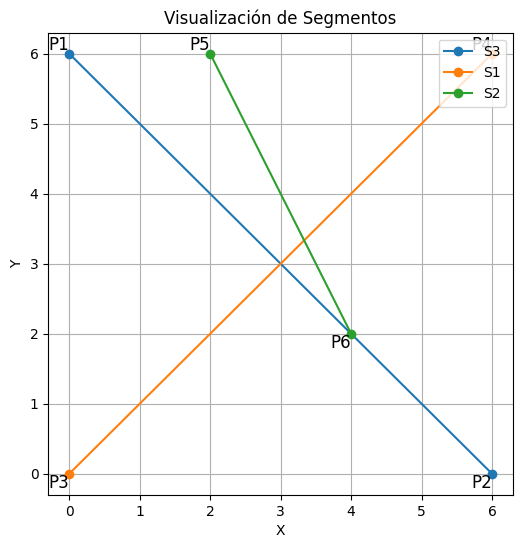

Intersección (3.3333333333333335, 3.3333333333333335)
{S1 (Upper: P4, Lower: P3), S2 (Upper: P5, Lower: P6)}
Intersección (4.0, 2.0)
{S2 (Upper: P5, Lower: P6), S3 (Upper: P1, Lower: P2)}
P6 (4, 2)
{S2 (Upper: P5, Lower: P6), S3 (Upper: P1, Lower: P2)}
Intersección (3.0, 3.0)
{S1 (Upper: P4, Lower: P3), S3 (Upper: P1, Lower: P2)}
Intersección (3.3333333333333335, 3.3333333333333335)
{S1 (Upper: P4, Lower: P3), S2 (Upper: P5, Lower: P6)}


In [ ]:
# Definimos los puntos
p1 = Points((0, 6), "P1")
p2 = Points((6, 0), "P2")
p3 = Points((0, 0), "P3")
p4 = Points((6, 6), "P4")
p5 = Points((2, 6), "P5")
p6 = Points((4, 2), "P6")

# Creamos los segmentos
s1 = Segment(p1, p2)
s1.reset_count()  # Diagonal de (0,6) a (6,0)
s2 = Segment(p3, p4)  # Diagonal de (0,0) a (6,6)
s3 = Segment(p5, p6)  # Línea de (2,6) a (4,2)

segments = [s1, s2, s3]

plot_segments(segments)
eventos_cola = generar_eventos(segments)

resultado = {}
estado_LB = ELB()

while len(eventos_cola) > 0:
    evento = eventos_cola.pop(0)
    estado_LB.insert(evento)
    
    if len(estado_LB.inorder())>1:
        p = evento.punto
        segmentos = estado_LB.inorder()
        upper_p, lower_p, contain_p = manipular_punto_p(p, eventos_cola, segmentos)
        
        # resultado.append((upper_p, lower_p, contain_p))
        union_total = upper_p | lower_p | contain_p
        
        if len (union_total) > 1:
            resultado[p]=union_total
        #eliminar segmentos que no están en la intersección (4)
        for i in lower_p | contain_p:
            estado_LB.eliminar_segmento(i)        
        #Insertar en TAO los segmentos en U(p) ∪ C(p)
        for i in upper_p | contain_p:
            estado_LB.insert(i)
        estado_LB.ordenar_justo_debajo(p)


        conjunto_cp_up = upper_p | contain_p
        if len (conjunto_cp_up)==0:
            Sl, Sr = estado_LB.encontrar_vecinos(p)
            if Sr != None and Sl != None:
                # print(Sr)
                # print(Sl)
                val = evaluar_interseccion(Sl,Sr)
                if val != None:
                    insertar_evento(eventos_cola, val)
               
            
        else :
            s_prima, Sl = estado_LB.encontrar_segmentos_izquierda(p, conjunto_cp_up)

            if s_prima != None and Sl != None:

                val = evaluar_interseccion(s_prima,Sl)
                if val != None:
                    insertar_evento(eventos_cola, val)
            

            S_doble_prima, Sr = estado_LB.encontrar_segmentos_derecha(p, conjunto_cp_up)
            if S_doble_prima != None and Sr != None:
                val = evaluar_interseccion(S_doble_prima,Sr)
                if val != None:
                    insertar_evento(eventos_cola, (evaluar_interseccion(S_doble_prima,Sr)))
            

for keys in resultado:
    print(keys)
    print(resultado[keys])







In [23]:
def procesar_eventos(segments):
    eventos_cola = generar_eventos(segments)
    estado_LB = ELB()
    resultado = {}
    
    while eventos_cola:
        evento = eventos_cola.pop(0)
        estado_LB.insert(evento)
        
        if len(estado_LB.inorder()) > 1:
            p = evento.punto
            segmentos = estado_LB.inorder()
            upper_p, lower_p, contain_p = manipular_punto_p(p, eventos_cola, segmentos)
            
            union_total = upper_p | lower_p | contain_p
            if len(union_total) > 1:
                resultado[p] = union_total
            
            # Actualizar estado de la línea de barrido
            for seg in (lower_p | contain_p):
                estado_LB.eliminar_segmento(seg)
                
            for seg in (upper_p | contain_p):
                estado_LB.insert(seg)
                
            estado_LB.ordenar_justo_debajo(p)
            
            # Manejar intersecciones
            conjunto_cp_up = upper_p | contain_p
            if not conjunto_cp_up:
                Sl, Sr = estado_LB.encontrar_vecinos(p)
                if Sr is not None and Sl is not None:
                    interseccion = evaluar_interseccion(Sl, Sr)
                    if interseccion is not None:
                        insertar_evento(eventos_cola, interseccion)
            else:
                # Verificar intersecciones a la izquierda
                s_prima, Sl = estado_LB.encontrar_segmentos_izquierda(p, conjunto_cp_up)
                if s_prima is not None and Sl is not None:
                    interseccion = evaluar_interseccion(s_prima, Sl)
                    if interseccion is not None:
                        insertar_evento(eventos_cola, interseccion)
                
                # Verificar intersecciones a la derecha
                s_doble_prima, Sr = estado_LB.encontrar_segmentos_derecha(p, conjunto_cp_up)
                if s_doble_prima is not None and Sr is not None:
                    interseccion = evaluar_interseccion(s_doble_prima, Sr)
                    if interseccion is not None:
                        insertar_evento(eventos_cola, interseccion)
    
    return resultado

In [24]:
procesar_eventos(segments)

{Intersección (3.3333333333333335, 3.3333333333333335): {S2 (Upper: P5, Lower: P6),
  S1 (Upper: P4, Lower: P3)},
 Intersección (4.0, 2.0): {S3 (Upper: P1, Lower: P2),
  S2 (Upper: P5, Lower: P6)},
 P6 (4, 2): {S3 (Upper: P1, Lower: P2), S2 (Upper: P5, Lower: P6)},
 Intersección (3.0, 3.0): {S3 (Upper: P1, Lower: P2),
  S1 (Upper: P4, Lower: P3)},
 Intersección (3.3333333333333335, 3.3333333333333335): {S2 (Upper: P5, Lower: P6),
  S1 (Upper: P4, Lower: P3)}}


=== Creación de Segmentos ===
Creado S1 (Upper: P1, Lower: P2)
Creado S2 (Upper: P4, Lower: P3)
Creado S3 (Upper: P5, Lower: P6)


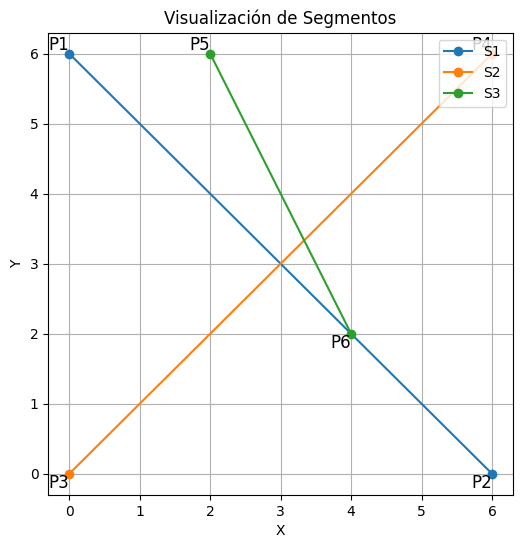


=== Generando eventos iniciales ===
Eventos iniciales generados: 6
  Evento(INICIO, Punto=P1, Segmentos=[S1])
  Evento(INICIO, Punto=P5, Segmentos=[S3])
  Evento(INICIO, Punto=P4, Segmentos=[S2])
  Evento(FIN, Punto=P6, Segmentos=[S3])
  Evento(FIN, Punto=P3, Segmentos=[S2])
  Evento(FIN, Punto=P2, Segmentos=[S1])

=== Iniciando procesamiento de eventos ===

--- Iteración 1 ---
Procesando evento: Evento(INICIO, Punto=P1, Segmentos=[S1])
Estado de la línea de barrido después de inserción:
Segmentos activos: [S1 (Upper: P1, Lower: P2)]

--- Iteración 2 ---
Procesando evento: Evento(INICIO, Punto=P5, Segmentos=[S3])
Estado de la línea de barrido después de inserción:
Segmentos activos: [S1 (Upper: P1, Lower: P2), S3 (Upper: P5, Lower: P6)]

Punto actual: P5 (2, 6)
Segmentos activos: [S1 (Upper: P1, Lower: P2), S3 (Upper: P5, Lower: P6)]
Clasificación de segmentos:
  Upper_p: set()
  Lower_p: set()
  Contain_p: {S3 (Upper: P5, Lower: P6)}

Actualizando estado de la línea de barrido...
  E

In [27]:
# Definimos los puntos y segmentos
p1 = Points((0, 6), "P1")
p2 = Points((6, 0), "P2")
p3 = Points((0, 0), "P3")
p4 = Points((6, 6), "P4")
p5 = Points((2, 6), "P5")
p6 = Points((4, 2), "P6")

s0 = Segment(p1, p2)
s0.reset_count()
print("\n=== Creación de Segmentos ===")
s1 = Segment(p1, p2)
print(f"Creado {s1}")
s2 = Segment(p3, p4)
print(f"Creado {s2}")
s3 = Segment(p5, p6)
print(f"Creado {s3}")

segments = [s1, s2, s3]
plot_segments(segments)
print("\n=== Generando eventos iniciales ===")
eventos_cola = generar_eventos(segments)
print(f"Eventos iniciales generados: {len(eventos_cola)}")
for e in eventos_cola:
    print(f"  {e}")

resultado = {}
estado_LB = ELB()
print("\n=== Iniciando procesamiento de eventos ===")

iteracion = 1
while len(eventos_cola) > 0:
    print(f"\n--- Iteración {iteracion} ---")
    evento = eventos_cola.pop(0)
    print(f"Procesando evento: {evento}")
    
    estado_LB.insert(evento)
    print(f"Estado de la línea de barrido después de inserción:")
    print(f"Segmentos activos: {estado_LB.inorder()}")
    
    if len(estado_LB.inorder()) > 1:
        p = evento.punto
        segmentos = estado_LB.inorder()
        print(f"\nPunto actual: {p}")
        print(f"Segmentos activos: {segmentos}")
        
        upper_p, lower_p, contain_p = manipular_punto_p(p, eventos_cola, segmentos)
        print(f"Clasificación de segmentos:")
        print(f"  Upper_p: {upper_p}")
        print(f"  Lower_p: {lower_p}")
        print(f"  Contain_p: {contain_p}")
        
        union_total = upper_p | lower_p | contain_p
        if len(union_total) > 1:
            resultado[p] = union_total
            print(f"¡Intersección encontrada en {p}!")
            print(f"Segmentos involucrados: {union_total}")
        
        print("\nActualizando estado de la línea de barrido...")
        for i in lower_p | contain_p:
            print(f"  Eliminando: {i}")
            estado_LB.eliminar_segmento(i)
        
        for i in upper_p | contain_p:
            print(f"  Insertando: {i}")
            estado_LB.insert(i)
        
        estado_LB.ordenar_justo_debajo(p)
        print(f"Nuevo estado después de ordenar: {estado_LB.inorder()}")

        conjunto_cp_up = upper_p | contain_p
        print(f"\nConjunto C(p) ∪ U(p): {conjunto_cp_up}")
        
        if len(conjunto_cp_up) == 0:
            print("Buscando vecinos...")
            Sl, Sr = estado_LB.encontrar_vecinos(p)
            print(f"  Vecino izquierdo: {Sl}")
            print(f"  Vecino derecho: {Sr}")
            
            if Sr is not None and Sl is not None:
                val = evaluar_interseccion(Sl, Sr)
                if val is not None:
                    print(f"  ¡Nueva intersección potencial encontrada!: {val}")
                    insertar_evento(eventos_cola, val)
        
        else:
            print("\nBuscando intersecciones con vecinos...")
            s_prima, Sl = estado_LB.encontrar_segmentos_izquierda(p, conjunto_cp_up)
            print(f"Izquierda - S': {s_prima}, Sl: {Sl}")
            
            if s_prima is not None and Sl is not None:
                val = evaluar_interseccion(s_prima, Sl)
                if val is not None:
                    print(f"  ¡Nueva intersección izquierda encontrada!: {val}")
                    insertar_evento(eventos_cola, val)

            S_doble_prima, Sr = estado_LB.encontrar_segmentos_derecha(p, conjunto_cp_up)
            print(f"Derecha - S'': {S_doble_prima}, Sr: {Sr}")
            
            if S_doble_prima is not None and Sr is not None:
                val = evaluar_interseccion(S_doble_prima, Sr)
                if val is not None:
                    print(f"  ¡Nueva intersección derecha encontrada!: {val}")
                    insertar_evento(eventos_cola, val)
    
    iteracion += 1

print("\n=== Resultados finales ===")
for keys in resultado:
    print(f"\nIntersección en punto: {keys}")
    print(f"Segmentos involucrados: {resultado[keys]}")

In [38]:
# Definimos los puntos y segmentos
p1 = Points((0, 6), "P1")
p2 = Points((6, 0), "P2")
p3 = Points((0, 0), "P3")
p4 = Points((6, 6), "P4")
p5 = Points((2, 6), "P5")
p6 = Points((4, 2), "P6")

s0 = Segment(p1, p2)
s0.reset_count()
print("\n=== Creación de Segmentos ===")
s1 = Segment(p1, p2)
# print(f"Creado {s1}")
s2 = Segment(p3, p4)
# print(f"Creado {s2}")
s3 = Segment(p5, p6)
# print(f"Creado {s3}")

segments = [s1, s2, s3]
# plot_segments(segments)
print("\n=== Generando eventos iniciales ===")
eventos_cola = generar_eventos(segments)
print(f"Eventos iniciales generados: {len(eventos_cola)}")
for e in eventos_cola:
    if e.tipo == "INICIO":
        print(f"Evento: {e}")
       


=== Creación de Segmentos ===

=== Generando eventos iniciales ===
Eventos iniciales generados: 6
Evento: Evento(INICIO, Punto=P1, Segmentos=[S1])
Evento: Evento(INICIO, Punto=P5, Segmentos=[S3])
Evento: Evento(INICIO, Punto=P4, Segmentos=[S2])
